In [448]:
import numpy as np
import pickle
import numpy.matlib
import matplotlib.pyplot as plt

# d = 3072
# k = 10
# n = 10000

In [449]:
###############################################################

# Matlab -> Python functions

###############################################################

# Loades an entire batch
def LoadBatch(filename):
	""" Copied from the dataset website """ 
	with open('Datasets/'+filename, 'rb') as fo:
		dict = pickle.load(fo, encoding='bytes') 
	return dict

# Calculate softmax for class class estimation of each image (vector)
def softmax(x):
	""" Standard definition of the softmax function """
	return np.exp(x) / np.sum(np.exp(x), axis=0)

# Compute Grads numerically (rather than my analytical approach)
def ComputeGradsNumSlow(X, Y, P, W, b, lamda, h):
	""" Converted from matlab code """
	no 	= 	W.shape[0]
	d 	= 	X.shape[0]

	grad_W = np.zeros(W.shape);
	grad_b = np.zeros((no, 1));
	
	for i in range(len(b)):
		b_try = np.array(b)
		b_try[i] -= h
		c1 = ComputeCost(X, Y, W, b_try, lamda)

		b_try = np.array(b)
		b_try[i] += h
		c2 = ComputeCost(X, Y, W, b_try, lamda)

		grad_b[i] = (c2-c1) / (2*h)

	for i in range(W.shape[0]):
		for j in range(W.shape[1]):
			W_try = np.array(W)
			W_try[i,j] -= h
			c1 = ComputeCost(X, Y, W_try, b, lamda)

			W_try = np.array(W)
			W_try[i,j] += h
			c2 = ComputeCost(X, Y, W_try, b, lamda)

			grad_W[i,j] = (c2-c1) / (2*h)

	return [grad_W, grad_b]

# Allows for efficiently view the images in a directory or 
# in a *Matlab* array or cell array
def montage(W):
	""" Display the image for each label in W """
	import matplotlib.pyplot as plt
	fig, ax = plt.subplots(2,5)
	for i in range(2):
		for j in range(5):
			im  = W[i*5+j,:].reshape(32,32,3, order='F')
			sim = (im-np.min(im[:]))/(np.max(im[:])-np.min(im[:]))
			sim = sim.transpose(1,0,2)
			ax[i][j].imshow(sim, interpolation='nearest')
			ax[i][j].set_title("y="+str(5*i+j))
			ax[i][j].axis('off')
	plt.show()

###############################################################

# My functions

###############################################################

# Read pixel data, labels (classes), one-hot rep. of labels (classes)
# Divide pixel data by 255 for correct format
def ReadData(filename):
    
    data_batch = LoadBatch(filename)
    pixel_data = data_batch[b'data']/255
    labels = data_batch[b'labels']
    one_hot = np.eye(10)[labels].T
    return pixel_data, one_hot, labels

# Get mean and standard deviaiton of (training) data
def GetMeanAndStd(data):  
    # Kanske ändra
    mean = np.mean(data, 0)
    std = np.std(data, 0) # nånting saknas 
    return mean, std

# Normalize w.r.t. training data mean and standard deviation
# Normalization of input so that the inputs are at a comparable range
def Normalize(train, validation, test, mean, std):
        
        # convert to floats
        train = np.float64(train)
        validation = np.float64(validation)
        test = np.float64(test)
        
        train -= mean 
        train /= std
    
        validation -= mean
        validation /= std
        
        test -= mean
        test /= std
        
        return train.T, validation.T, test.T

# First init of model params W(eights) and b(ias)
# Init done with 0 mean and .01 std
# Random seed for selecting the same rndm numbers for each execution
def GetWeightAndBias(X, Y):
    
    W_size = X.shape
    b_size = Y.shape

    np.random.seed(400)
    W = np.random.normal(loc=0.0, scale=0.01, size=(10, 3072))
    np.random.seed(400)
    b = np.random.normal(loc=0.0, scale=0.01, size=(b_size[0], 1))

    return W, b

# Evaluation of the network function
# Agan, Softmax returns each probability for each class label
def EvaluateClassifier(X, W, b):

    s = np.dot(W, X) + b
    P = softmax(s)
    
    return P

# Total cost of a set of images:
# 1. Regularization term, calculate: lambda * sum(W^2 ij)
# 2. Sum it with l_cross + regularization term -> for each x,y in D
# 3. Multiply everything with 1 / length of D
def ComputeCost(X, Y, W, b, lambd):

    # Calculate P using softmax
    P = EvaluateClassifier(X, W, b)
    
    # Calculate cross-entropy-loss
    l_cross = -np.sum(np.multiply(Y, np.log(P)))
    
    # Calculate regularization term
    reg_term = lambd * np.sum(np.square(W))
    
    # Calculate total cost of the set of imgs
    J = (1 / len(X[1])) * l_cross + reg_term
    
    return J

# Accuracy of the network's predictions
# Percentage of examples for which it gets the correct answer
def ComputeAccuracy(X, y, W, b):

    P = EvaluateClassifier(X,W,b)
    acc = np.mean(y == np.argmax(P, axis=0))
    
    return acc
    
# Compute gradients of the cost function to see the curve of cost decrease 
# Forward pass is already done since we have already calculated P
def ComputeGradients(X, Y, P, W, lambd):

    n_b = X.shape[1]
    
    # Backward pass
    G_batch = -(Y - P)
    
    # Backward pass for W + reg term
    grad_W = 1 / n_b * np.dot(G_batch, X.T) + 2 * lambd * W
    
    # Backward pass for b
    grad_b = 1 / n_b * np.dot(G_batch, np.ones(shape=(n_b, 1)))
    
    return grad_W, grad_b

# Check if my analytical gradients 
# Using centered difference function
# If the differenc is < 1e-6, the analytical gradients are fine
def CompareGradients(X, Y, W, b, lambd, h):
    
    P = EvaluateClassifier(X, W, b)
    
    #Calculate gradients
    grad_W_a, grad_b_a = ComputeGradients(X, Y, P, W, lambd)
    grad_W_n, grad_b_n = ComputeGradsNumSlow(X, Y, P, W, b, lambd, h)
    
    # Calculate differences
    w_rel_error = np.sum(np.abs(grad_W_a - grad_W_n)) / np.maximum(0.001, np.sum(np.abs(grad_W_a) + np.abs(grad_W_n)))
    b_rel_error = np.sum(np.abs(grad_b_a - grad_b_n)) / np.maximum(0.001, np.sum(np.abs(grad_b_a) + np.abs(grad_b_n)))

    # Check differences
    if w_rel_error < 1e-6 and b_rel_error < 1e-6:
        print("Analytical ok")
    else:
        print("Gradient difference too high")

# Optimization of parameters with mini batch GD
# Here, we update W and b for each epoch 
# Note: Differs from other approaches such as Batch Gradient Descent and Stochastic GD
def MiniBatchGD(X, Y, GDparams, W, b, lambd):
    
    cost_list = []
    accuracy_list = []
    s_im = np.zeros((32,32,3))
    n_batch = GDparams['n_batch']
    epochs = GDparams['n_epochs']
    learning_rate = GDparams['eta']

    n = X.shape[1]
    
    for i in range(epochs):
        for j in range(n // n_batch):
            
            # Selecting random entries
            j_start = j*n_batch
            j_end = (j+1) * n_batch
            inds = range(j_start, j_end)
            
            # Random subset of train and corr. labels
            XBatch = X[:, inds]
            YBatch = Y[:, inds]

            # Fwd pass on mini batch
            P = EvaluateClassifier(XBatch, W, b)
            
            # Backward pass on mini batch
            grad_W, grad_b = ComputeGradients(XBatch, YBatch, P, W, lambd)
            
            # Update parameters for next iteration
            W = W - learning_rate * grad_W 
            b = b - learning_rate * grad_b

        # Append accuracy and cost to list for each epoch
        accuracy_list.append(ComputeAccuracy(X_train_normalized, y_test, W, b))
        cost_list.append(ComputeCost(XBatch, YBatch, W, b, lambd))
     
    return cost_list, accuracy_list, s_im, W, b

In [450]:
# Read data
X_train, Y_train, y_test = ReadData('data_batch_1')
X_val_train, Y_val_train, y_val_test = ReadData('data_batch_2')
X_test_train, Y_test_train, y_test_test = ReadData('test_batch')

# Gets mean and std of training data
X_mean, X_std = GetMeanAndStd(X_train)

In [451]:
# Normalize all data w.r.t. mean and std of training data
X_train_normalized, X_val_train_normalized, X_test_train_normalized = Normalize(X_train, X_val_train, X_test_train, X_mean, X_std)

In [452]:
# Create model params W and b
W, b = GetWeightAndBias(X_train_normalized, Y_train)

In [453]:
# Model evaluation (take softmax)
P = EvaluateClassifier(X_train_normalized, W, b)

In [454]:
# X = dxn array of images (columns)
# Y = 1xn vector of labels (in one-hot) for X
# J = scalar corresponing to sum of the loss of the network's predictions,
# in X relative to ground truth labels and reg. term on W. 
# Lambda = specifies how much penalty to be added 
J = ComputeCost(X_train_normalized, Y_train, W, b, lambd = 0.005)
print("Total cost: ", J)

Total cost:  2.4139380487029203


In [455]:
A = ComputeAccuracy(X_train_normalized, y_test, W, b)
print(A)

0.1053


In [456]:
grad_W, grad_b = ComputeGradients(X_train_normalized[0:20, [1]], Y_train[:,[1]], P[0:20, [1]], W[:, 0:20], lambd=0)

In [457]:
threshold = 1e-6
CompareGradients(X_train[0:20, [1]], Y_train[:, [1]], W[:, 0:20], b, 0, threshold)
#CompareGradients(X_train[0:1000, [1]], Y_train[:, [1]], W[:, 0:1000], b, 0, threshold)
#CompareGradients(X_train[0:3072, [1]], Y_train[:, [1]], W[:, 0:3072], b, 0, threshold)

Analytical ok


In [464]:
# Hyperparams
GDparams = {'n_batch': 100, 'eta': 0.001, 'n_epochs': 40}
lambd = 1

# Train data
cost, accuracy_list, s_im, W_upd, b_upd = MiniBatchGD(X_train_normalized, Y_train, GDparams, W, b, lambd)

# Validation data
cost_val, accuracy_list_val, s_im_val, W_upd_val, b_upd_val = MiniBatchGD(X_val_train_normalized, Y_val_train, GDparams, W, b, lambd)

# Test data
#cost_test, accuracy_list_test, s_im_val, W_upd_test, b_upd_test = MiniBatchGD(X_test_train_normalized, Y_test_train, GDparams, W, b, lambd)
Acc = ComputeAccuracy(X_test_train_normalized, y_test_test, W_upd, b_upd)

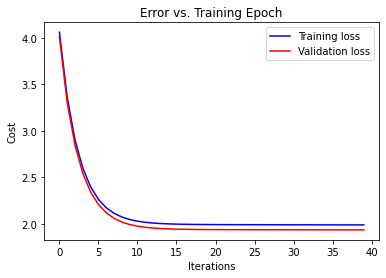

Current lambda: 1
Current n_batch: 100
Current eta: 0.001
Current n_epochs: 40
Accuracy test data:  0.3752


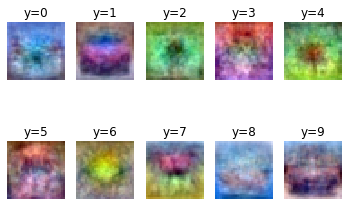

In [465]:
# Losses looks very weird compared to the ones in the assignment
# Also, why the hell is training losing more than validaiton
# Accuracy low AF
fig, ax = plt.subplots()  
ax.plot(np.arange(GDparams['n_epochs']), cost, 'b', label='Training loss')  
ax.plot(np.arange(GDparams['n_epochs']), cost_val, 'r', label='Validation loss') 
ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  
ax.set_title('Error vs. Training Epoch')
plt.legend()
plt.show()

print("Current lambda:", lambd) 
print("Current n_batch:", GDparams['n_batch'])
print("Current eta:", GDparams['eta'])
print("Current n_epochs:", GDparams['n_epochs'])
print("Accuracy test data: ", Acc)

# Visualization of weight matrix W for each epoch
montage(W_upd)

In [447]:
A = ComputeAccuracy(X_test_train_normalized, y_test_test, W_upd, b_upd)
print(A)

0.3893
